In [2]:
import ccxt, pandas as pd, indicateur_techniques as id, numpy as np, matplotlib.pyplot as plt

In [1]:
class Backtest:
	def __init__(self, capital):
		self.capital_initial = capital
		self.capital = capital

		self.positions_long = []
		self.quantite_position_long = []

		self.positions_short = []
		self.quantite_position_short = []


	def load_data(self, symbol='BTC/USDT', time='30m', length=500):
		#telecharcgement des donnée ohlcv
		self.exchange = ccxt.binance({
		'enableRateLimit': True,
		})
		try:
			ohlcv_data = self.exchange.fetch_ohlcv(symbol, time, limit=length)
			self.data = pd.DataFrame(ohlcv_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
			print("data dowload")

			self.data['position_long_open'] = None
			self.data['position_long_close'] = None

			self.data['position_short_open'] = None
			self.data['position_short_close'] = None

			self.data['evolution_price'] = None
		except ccxt.NetworkError:
			print("Problème lors du téléchargement des données")
		
	def open_long(self, close, pos, quantite=0.1):
		if not self.positions_long:
			self.positions_long.append(close)
			self.quantite_position_long.append(self.capital * quantite)
			print("open_long", close, "   ", pos)
			self.append_element_df("long_open", pos)
	
	def close_long(self, close, position, test=0):
		if self.positions_long:
			for pos in range(len(self.positions_long)):
				self.capital += (close - self.positions_long[pos]) * self.quantite_position_long[pos] # - (self.positions_long[pos] * self.quantite_position_long[pos] * 0.3
			self.positions_long.clear()
			self.quantite_position_long.clear()
			self.append_element_df("long_close", position)
			
			if test == 1:
				print("close garce au take_profit", close, "   ", position)
			elif test == 2:
				print("close garce au stop_loss", close, "   ", position)
			elif test == 0:
				print("close_short")
				print(close, "   ", position)
			else:
				print("choix_incorrect", test)
		
	def open_short(self, close, pos, quantite=0.1):
		if not self.positions_short:
			self.positions_short.append(close)
			self.quantite_position_short.append(self.capital * quantite)
			print("open_short", close, "   ", pos)
			self.append_element_df("short_open", pos)
	
	def close_short(self, close, position, test=0):
		if self.positions_short:
			for pos in range(len(self.positions_short)):
				self.capital += (self.positions_short[pos] - close)  * self.quantite_position_short[pos] # - (self.positions_short[pos] * self.quantite_position_short[pos] * 0.3)
			self.positions_short.clear()
			self.quantite_position_short.clear()
			self.append_element_df("short_close", position)
			
			if test == 1:
				print("close garce au take_profit", close, "   ", position)
			elif test == 2:
				print("close garce au stop_loss", close, "   ", position)
			elif test == 0:
				print("close_short", close, "   ", position)
			else:
				print("choix_incorrect", test)
				
	
	def show_evolution_price(self):
		self.data.evolution_price.plot()
	
	def update(self, pos, close):
		"""
		close_actuel
		"""
		self.take_profit(close, pos)
		self.stop_loss(close, pos)
		self.data.at[pos, 'evolution_price'] = self.capital
		if self.positions_long:
			print("___  ", ((close / self.positions_long[0]) - 1) * 100, "  ___")
		if self.positions_short:
			print("***  ", ((self.positions_short[0] / close) - 1) * 100, "  ***")
		
	
	def take_profit(self, close, position):
		if self.positions_long:
			
			if ((close / self.positions_long[0]) - 1) * 100 > 0.1:
				print("take_profit_long")
				print(((close / self.positions_long[0]) - 1) * 100)
				self.close_long(close, position, 1)
				
	
		if self.positions_short:
			if ((close / self.positions_short[0]) - 1) * 100 < -0.1:
				print("take_profit_short")
				print(((close / self.positions_short[0]) - 1) * 100)
				self.close_short(close, position, 1)
	
	def stop_loss(self, close, position):
		
		if self.positions_long:
			if ((close / self.positions_long[0]) - 1) * 100 < -0.5:
				print("stop_loss_long")
				print(((close / self.positions_long[0]) - 1) * 100)
				self.close_long(close, position, 2)

		if self.positions_short:
			if ((close / self.positions_short[0]) - 1) * 100 > 0.5:
				print("stop_loss_short")
				print(((close / self.positions_short[0]) - 1) * 100)
				self.close_short(close, position, 2)




	def look_money(self):
		print(f"Votre porte feuille contient {self.capital}$")
	
	def rendement_final(self):
		self.rendement = ((self.capital - self.capital_initial) / self.capital_initial) * 100
		print(f"Le taux d'évolution est de {self.rendement}$")
	
	def append_element_df(self, style:str, position):
		"""
		style doit être égale a :
		-short_open
		-short_close
		-long_open
		-long_close
		et position a ou on est dans le df
		"""
		if style == "short_open":
			self.data.at[position, 'position_short_open'] = True
		elif style == "short_close":
			self.data.at[position, 'position_short_close'] = True
		elif style == "long_open":
			self.data.at[position, 'position_long_open'] = True
		elif style == "long_close":
			self.data.at[position, 'position_long_close'] = True
		else:
			print("Error, the style is not correct")
	
	def graphique(self, list_indicateur:list):
		#lsit_indicateur doit contenir les df de tout les indicateur utiliser
		positions_so = list(np.where(self.data.position_short_open == True)[0])
		positions_sc = list(np.where(self.data.position_short_close == True)[0])
		positions_lo = list(np.where(self.data.position_long_open == True)[0])
		positions_lc = list(np.where(self.data.position_long_close == True)[0])

		for indicateur in list_indicateur:
			indicateur.plot()
		
		move = self.data.close.mean() * 0.0007
		for pos in positions_so:
			x = pos
			y = self.data.close[pos]
			plt.plot(x, y+move,'o', marker='v', markersize=7, label='Triangles', color='green')
		for pos in positions_sc:
			x = pos
			y = self.data.close[pos]
			plt.plot(x, y+move,'o', marker='v', markersize=7, label='Triangles', color='red')
		for pos in positions_lo:
			x = pos
			y = self.data.close[pos]
			plt.plot(x, y-move,'o', marker='^', markersize=7, label='Triangles', color='green')
		for pos in positions_lc:
			x = pos
			y = self.data.close[pos]
			plt.plot(x, y-move,'o', marker='^', markersize=7, label='Triangles', color='red')
		self.data.close.plot()


In [7]:
backtest_test = Backtest(1000)
backtest_test.load_data()
backtest_test.data["mm50"] = id.mm(backtest_test.data.close, 50)
backtest_test.data["mm100"] = id.mm(backtest_test.data.close, 100)
backtest_test.data["signal_long"] = backtest_test.data["mm100"] < backtest_test.data["mm50"]
backtest_test.data["signal_short"] = backtest_test.data["mm50"] < backtest_test.data["mm100"]
for i in range(len(backtest_test.data.close)):
	
	if backtest_test.data.signal_long[i] == True:
		backtest_test.open_long(backtest_test.data.close[i], i, 0.01)
	elif backtest_test.data.signal_long[i] == False:
		backtest_test.close_long(backtest_test.data.close[i], i)

	
	
	if backtest_test.data.signal_short[i] == True:
		backtest_test.open_short(backtest_test.data.close[i], i, 0.01)
	elif backtest_test.data.signal_short[i] == False:
		backtest_test.close_short(backtest_test.data.close[i], i)
	backtest_test.update(i, backtest_test.data.close[i])

data dowload
open_long
1.1203     39
close_long
1.1189     59
open_long
1.1178     104
close_long
1.1193     152


C:\Users\JB\AppData\Local\Temp\ipykernel_2760\776645866.py:117: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(x, y-move,'o', marker='^', markersize=7, label='Triangles', color='green')
C:\Users\JB\AppData\Local\Temp\ipykernel_2760\776645866.py:121: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(x, y-move,'o', marker='^', markersize=7, label='Triangles', color='red')


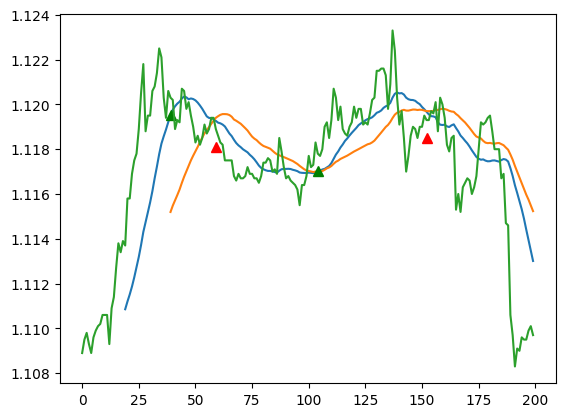

In [8]:
backtest_test.graphique([backtest_test.data.mm20, backtest_test.data.mm40])

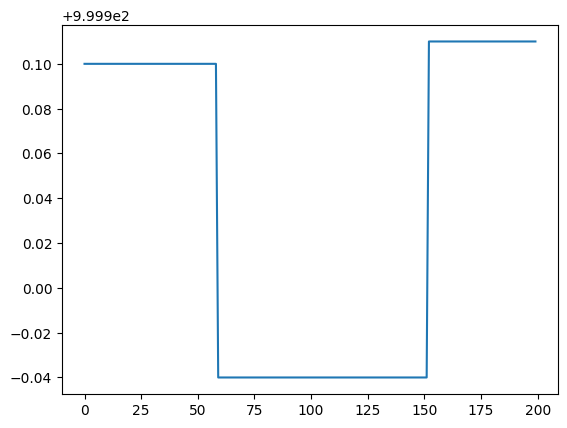

In [9]:
backtest_test.show_evolution_price()